In [534]:
# import relevant libraries (not all are used!!)
import numpy as np 
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt
%matplotlib inline
from shapely.geometry import Point
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier,\
GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
alpha_lass0 = []
from sklearn import linear_model

In [535]:
# read in the data
df = pd.read_csv('AB_NYC_2019.csv')
df2 = pd.read_csv('Neighborhood_Zhvi_AllHomes.csv')
df2 = df2[df2['City'] == 'New York']

In [536]:
# create a column which averages the median home prices for the year (as we have it the values are monthly; make this yearly)
df2['2019 value'] = (df2['2019-01']+df2['2019-02']+df2['2019-03']+df2['2019-04']+df2['2019-05']+df2['2019-06']+df2['2019-07']+df2['2019-08']+df2['2019-09'])/9
df_groupby = df2.groupby('RegionName')[['2019 value']].mean().sort_values(by = '2019 value')

In [537]:
# merge our two data sets together
merged = df.merge(df_groupby, how = 'left', left_on = 'neighbourhood', right_on = 'RegionName')
merged_na = merged[merged['2019 value'].isna()]
merged_notna = merged[merged['2019 value'].notna()]

In [538]:
# fill missing data by using the 5 nearest neighbors
merged['2019 value_2'] = merged.index.values
def nearest_n(i):
    n = 5
    if merged['2019 value'].isna().iloc[i] == True:
        lat, long = merged_na['latitude'].loc[i], merged_na['longitude'].loc[i]
        temp = merged_notna.copy()
        temp['distance'] = ((temp['latitude'] - float(lat))**2 + (temp['longitude'] - float(long))**2)**.5
        min_series = temp['distance'].sort_values()[:n]
        values = []
        for j in min_series.index.values:
            values.append(merged_notna['2019 value'].loc[j])
        return sum(values)/len(values)
    else:
        return merged['2019 value'].iloc[i]
merged['2019 value_2'] = merged['2019 value_2'].apply(nearest_n)

In [539]:
merged.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,2019 value,2019 value_2
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,10/19/2018,0.21,6,365,1.018244e+06,1.018244e+06
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,5/21/2019,0.38,2,355,1.270278e+06,1.270278e+06
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,NaN,8.011444e+05
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,7/5/2019,4.64,1,194,9.657889e+05,9.657889e+05
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,11/19/2018,0.10,1,0,8.011444e+05,8.011444e+05


# airbnb and subway distances

In [540]:
# read in the new york background for our plots
# then, since this is a csv file, convert the geometry column text into well known text, this will allow you to plot its geometry correctly
# now convert the pandas dataframe into a Geopandas GeoDataFrame
nyc = pd.read_csv('nynta.csv')
nyc['geom']=nyc['the_geom'].apply(wkt.loads)
nyc = gpd.GeoDataFrame(nyc, geometry='geom')

In [541]:
# read in the subway data
subways = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

# Change one subway value that is incorrectly positive
subways.at[261, 'Entrance Longitude'] = subways.iloc[261]['Entrance Longitude'] * -1

In [542]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(subways['Entrance Longitude'], subways['Entrance Latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
subways_geo = gpd.GeoDataFrame(subways, crs=crs, geometry=geometry)

In [543]:
# creating a geometry column for AirBnB data
geometry = [Point(xy) for xy in zip(merged['longitude'], merged['latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
df_geo = gpd.GeoDataFrame(merged, crs=crs, geometry=geometry)

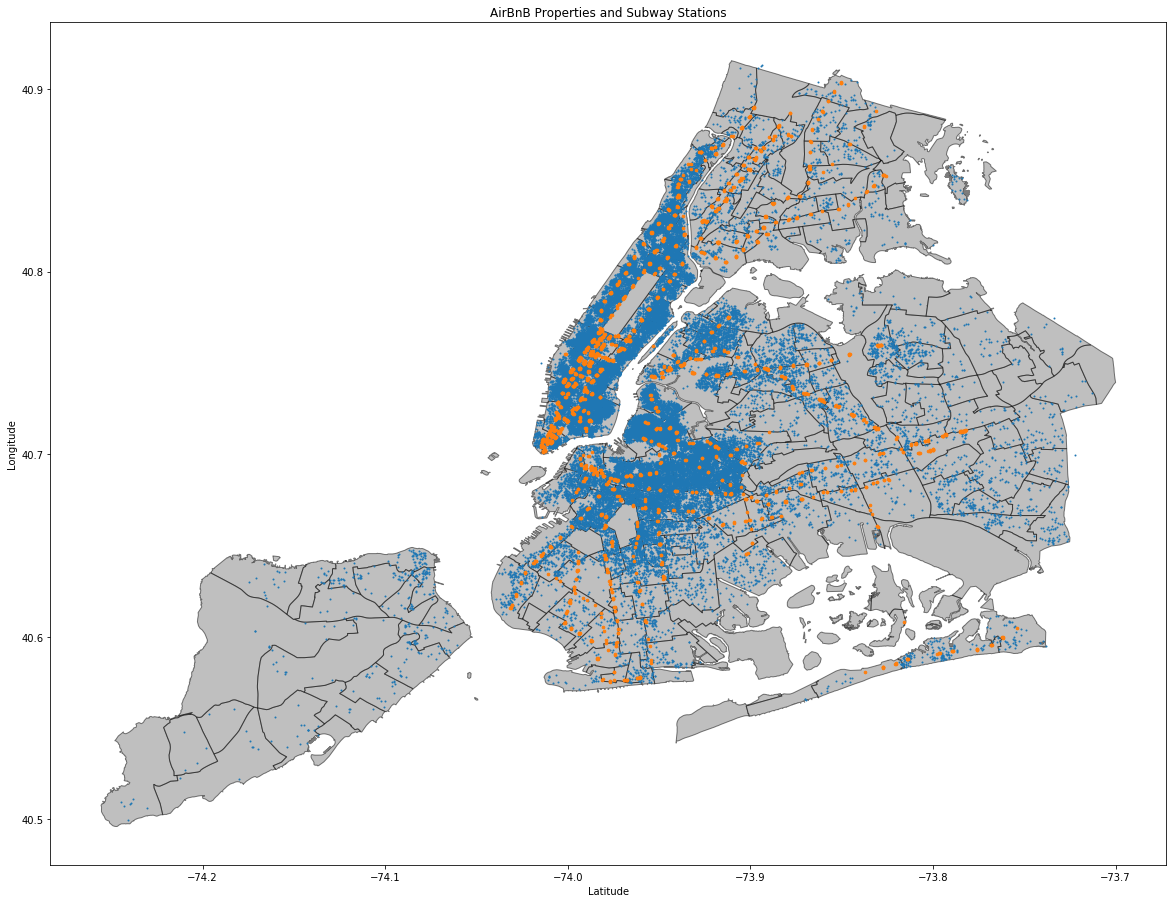

In [544]:
# plot airbnb properties vs subway stations
fig,ax1 = plt.subplots(1,1, figsize=(20,20))
base = nyc.plot(color = 'gray', alpha=0.5, edgecolor='black', ax=ax1)
df_geo.plot(markersize=1, ax=base)
subways_geo.plot(markersize=6.7,ax=base)
plt.title('AirBnB Properties and Subway Stations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [545]:
# calculate subway distance
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [546]:
# Put subway locations in a list
a = subways_geo['Entrance Latitude'].values.tolist()
b = subways_geo['Entrance Longitude'].values.tolist()
subway_locations = []
for index, latitude in enumerate(a): 
    temp = [b[index], latitude]
    subway_locations.append(temp)

In [547]:
# Function to Calculate distance to closest Subway Station, Find the Closest Station, and calculate the distance
def closest_subway(index):
    city_coord = df_geo['longitude'].iloc[index], df_geo['latitude'].iloc[index]
    min_distance = 1000000
    
    for subway_loc in subway_locations:
        distance = haversine(city_coord, subway_loc)    
        if (distance < min_distance):
            min_distance = distance
    
    return min_distance

In [548]:
 # Save closest Subway into new column
df_geo['index'] = df_geo['id'].index
df_geo['Closest Subway'] =  df_geo['index'].map(closest_subway)

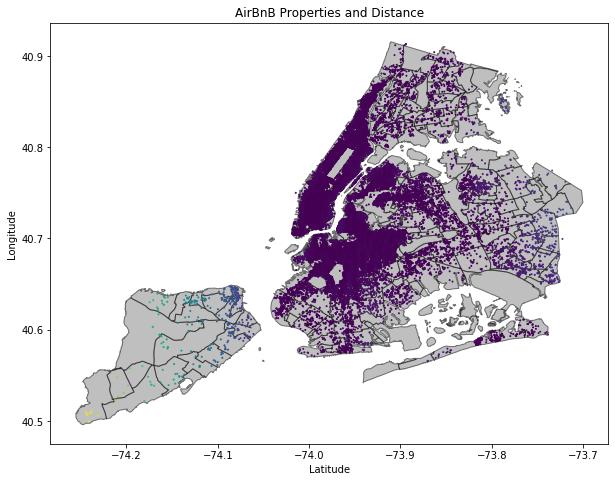

In [549]:
# plot airbnb subway distances
fig,ax1 = plt.subplots(1,1, figsize=(10,10))
base = nyc.plot(color = 'gray', alpha=0.5, edgecolor='black', ax=ax1)
df_geo[df_geo['price'] < 2000].plot(markersize = 1,c = df_geo['Closest Subway'][df_geo['price'] < 2000],ax=base)

plt.title('AirBnB Properties and Distance')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [550]:
# create a funciton to plot subway distances
def boro_plot(boro_name):
    mask = nyc['BoroName'] == boro_name
    mask2 = (df_geo['neighbourhood_group'] == boro_name)&(df_geo['price'] < 2000)
    fig,ax1 = plt.subplots(1,1, figsize=(10,8))
    base = nyc[mask].plot(color = 'gray', alpha=0.5, edgecolor='black', ax=ax1)
    df_geo[mask2].plot(markersize = 10,c = df_geo[mask2]['Closest Subway'],ax=base)

    plt.title('AirBnB properties and Price')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()

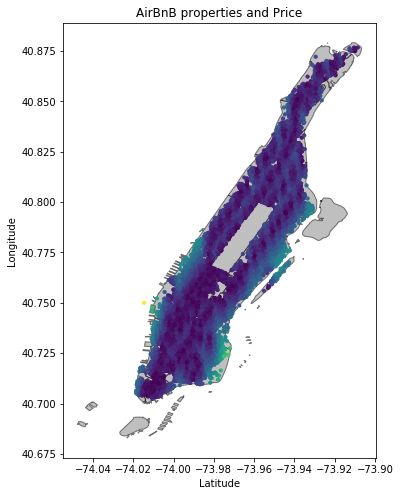

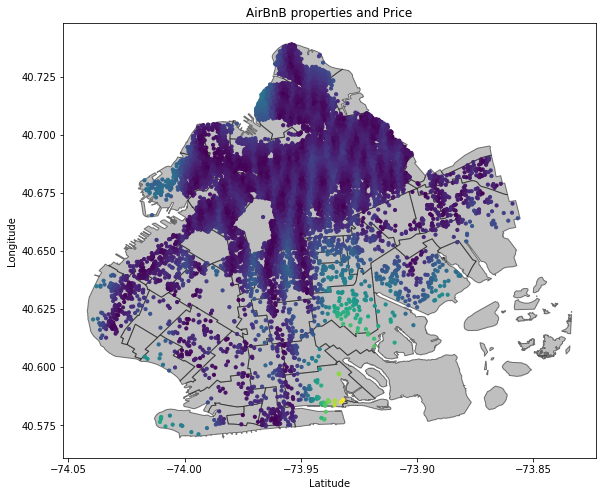

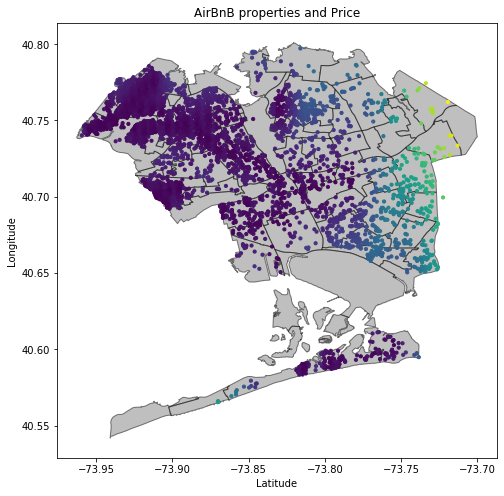

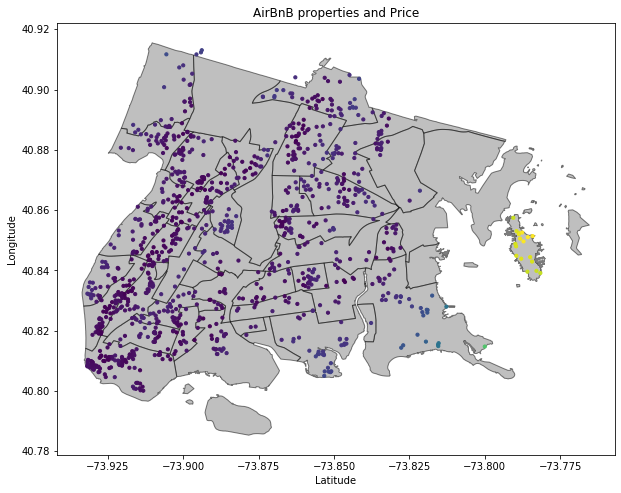

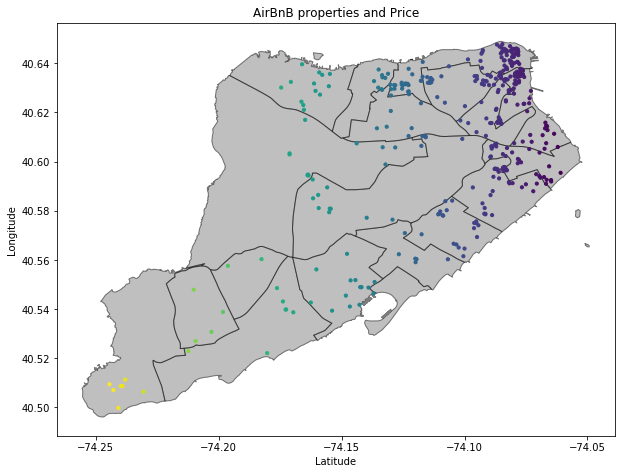

In [551]:
# call the above function
boro_plot('Manhattan')
boro_plot('Brooklyn')
boro_plot('Queens')
boro_plot('Bronx')
boro_plot('Staten Island')

Text(0.5, 1.0, 'Closest Subway vs. Price')

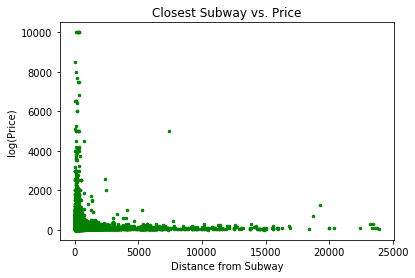

In [552]:
# plot the subway distance vs price to see relationship
plt.plot(df_geo['Closest Subway'], df_geo['price'], color='green', marker='.', markersize=5, linestyle = 'none')
plt.xlabel('Distance from Subway')
plt.ylabel('log(Price)')
plt.title('Closest Subway vs. Price')

Text(0.5, 1.0, 'Closest Subway vs. log(Price)')

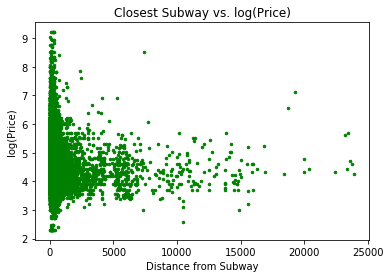

In [556]:
# plot the subway distances against log(price) to see relationship
min_value = df_geo['price_log'].min()
new = df_geo[df_geo['price_log'] != min_value]
new['price_log'] = np.log(new['price'])
plt.plot(new['Closest Subway'], new['price_log'], color='green', marker='.', markersize=5, linestyle = 'none')
plt.xlabel('Distance from Subway')
plt.ylabel('log(Price)')
plt.title('Closest Subway vs. log(Price)')

# Modeling

In [ ]:
# replace missing values with zeros in the reviews_per_month column
new['reviews_per_month'] = new['reviews_per_month'].fillna(0)

In [595]:
# we eliminate outliers here (this takes out a very small portion of our data, around .2%)
new2 = new[new['price'] < 2000]
1 - len(new2)/len(df_geo)

0.002474690663667012

In [588]:
# we use the preprocessing from a previous homework to one-hot encode and select features
from sklearn.pipeline import Pipeline, FeatureUnion
class OneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self,col):
        self.col = col
                
    def transform(self, X):
        return pd.get_dummies(X[self.col]) 

    def fit(self, X, y=None):
        return self  
    
# Stateless transformer for selecting a specified columns
class DFSubsetSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self,cols):
        self.cols = cols
        
    def transform(self ,X):
        return X[self.cols]
    
    def fit(self, X, y=None):
        return self
    
class ConcatFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self,cols,sep="_"):
        self.cols = cols
        self.sep = sep
                
    def transform(self, X):
        concat_col = self.sep.join(self.cols)
        return X.apply(lambda x : self.sep.join([x[col] for col in self.cols]) ,axis=1).to_frame(name = concat_col)

    def fit(self, X, y=None):
        return self  
    
# Transformer that does min-max transform on the specified columns
class MinMaxTransform(BaseEstimator, TransformerMixin):

    def __init__(self,cols=None):
        self.cols = cols
        self.minVec = np.zeros(len(cols))
        self.maxVec = np.zeros(len(cols))
       
    def transform(self, X):
        X[self.cols] = ((X[self.cols] - self.minVec)/(self.maxVec-self.minVec))
        return X

    def fit(self, X, y=None):
        self.minVec = (df_train[self.cols].min())
        self.maxVec = (df_train[self.cols].max())
        return self

In [589]:
# run 50 multiple linear regression models and average their error together
cat_vars = ['room_type', 'neighbourhood_group']
continuous_vars = ['Closest Subway', '2019 value_2', 'latitude', 'longitude']

categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars))])
all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])

linear_error = []
for i in range(50):
    x = new2[['Closest Subway','2019 value_2', 'room_type', 'latitude', 'longitude', 'neighbourhood_group']]
    y = new2['price_log']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    model = Pipeline([('preprocessor', all_feature_preprocessor), ('model', LinearRegression())])
    model.fit(x_train,y_train)
    
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_pred,y_test)
    linear_error.append(mse)
print(sum(linear_error)/len(linear_error))

0.22988758596996908


In [594]:
# try running multiple linear regression by borough (an example provided here)
cat_vars = ['room_type']
continuous_vars = ['Closest Subway', '2019 value_2', 'latitude', 'longitude', 'availability_365']

categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars))])
all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])
boro_error = []
for i in range(1,20):
    temp = new[(new['neighbourhood_group'] == 'Manhattan')]
    x = temp[['Closest Subway','2019 value_2', 'availability_365','room_type', 'latitude', 'longitude']]
    y = temp['price_log']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    model = Pipeline([('preprocessor', all_feature_preprocessor), ('model', LinearRegression())])
    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    boro_error.append(mse)
print(sum(boro_error)/len(boro_error))

0.2637187815465949


In [596]:
# run a ridge regression model
cat_vars = ['room_type','neighbourhood_group']
continuous_vars = ['Closest Subway', '2019 value_2','latitude','longitude', 'availability_365']

categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars))])
all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])

error_list_ridge = []
alpha = []
for i in range(50):
    x = new2[['2019 value_2', 'room_type', 'neighbourhood_group', 'latitude', 'longitude', 'Closest Subway', 'availability_365']]
    y = new2['price_log']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    alphas = np.array([.3,.2,0.1,0.01,0.001,0.0001,0, .4, .5, 1, 2, 3, .00001])
    model = Ridge()
    grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
    model = Pipeline([('preprocessor', all_feature_preprocessor), ('model', grid)])

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    error_list_ridge.append(mse)
    alpha.append(grid.best_estimator_.alpha)
    i+=1
print('Average Error =', sum(error_list_ridge)/len(error_list_ridge))
print('Average Alpha =', sum(alpha) / len(alpha))

Average Error = 0.22746604520802902
Average Alpha = 0.07940040000000001


In [608]:
# define a function to run a ridge regression by borough
cat_vars = ['room_type']
continuous_vars = ['Closest Subway', '2019 value_2','latitude','longitude', 'availability_365']

categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars))])
all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])

def ridge_regressor(boro):
    error_list_ridge2 = []
    alpha2 = []
    for i in range(50):
        temp = new2[(new2['neighbourhood_group'] == boro)]
        x = temp[['Closest Subway','2019 value_2','room_type','latitude','longitude','availability_365']]

        y = temp['price_log']
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

        alphas = np.array([.3,.2,0.1,0.01,0.001,0.0001,0, .4, .5, 1, 2, 3, .00001])
        grid = GridSearchCV(estimator=Ridge(), param_grid=dict(alpha=alphas))
        model = Pipeline([('preprocessor', all_feature_preprocessor), ('model', grid)])

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        mse = mean_squared_error(y_pred, y_test)
        error_list_ridge2.append(mse)
        alpha2.append(grid.best_estimator_.alpha)
        i+=1
    print('Average Error =', sum(error_list_ridge2) / len(error_list_ridge2))
    print('Average Alpha =', sum(alpha2) / len(alpha2))

In [609]:
# run the above function for different boroughs
ridge_regressor('Manhattan')

Error = 0.23346316595559
Error = 0.0248206


In [611]:
ridge_regressor('Queens')

Error = 0.20366857171223604
Error = 0.1752002


In [614]:
ridge_regressor('Bronx')

Error = 0.21985253905318203
Error = 1.2264


In [617]:
ridge_regressor('Brooklyn')

Error = 0.19271174702800487
Error = 0.0051800000000000014


In [618]:
# run a lasso regression model
cat_vars = ['room_type', 'neighbourhood_group']
continuous_vars = ['Closest Subway', '2019 value_2','latitude','longitude']

categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars))])
all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])

error_list_lasso = []
alpha_lasso = []
for i in range(20):
    
    x = new2[['Closest Subway','2019 value_2','room_type', 'neighbourhood_group','latitude','longitude']]
    y = new2['price_log']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    alphas = np.array([.3,.2,0.1,0.01,0.001,0.0001,0, .4, .5, 1, 2, 3, .00001])
    grid = GridSearchCV(estimator=linear_model.Lasso(), param_grid=dict(alpha=alphas), cv=5)
    model = Pipeline([('preprocessor', all_feature_preprocessor), ('model', grid)])

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mse = mean_squared_error(y_pred, y_test)
    error_list_lasso.append(mse)
    alpha_lasso.append(grid.best_estimator_.alpha)
    i+=1
print('Average Error =', sum(error_list_lasso) / len(error_list_lasso))
print('Average Alpha =', sum(alpha_lasso) / len(alpha_lasso))

Error = 0.23068729434031904
Alpha = 6e-06


In [600]:
# run a random forest model
cat_vars = ['room_type','neighbourhood_group', 'neighbourhood']
continuous_vars = ['Closest Subway', '2019 value_2','latitude','longitude', 'availability_365', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                  'calculated_host_listings_count']

categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars))])
all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])

x = new2.drop(columns = ['price', 'price_log'])
x = all_feature_preprocessor.fit_transform(x)
y = new2['price_log']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = RandomForestRegressor(n_estimators = 500)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

mse = mean_squared_error(y_pred, y_test)
print(mse)

0.17834358861618718


In [602]:
# get feature importance for the random forest model (an error is thrown after the 10th feature and I do not know why
# but we only wanted the first 8-10 anyway)
z = new2[['room_type','neighbourhood_group', 'neighbourhood','Closest Subway', '2019 value_2','latitude','longitude', 'availability_365', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                  'calculated_host_listings_count']]

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
x_train = pd.DataFrame(x_train)

for f in range(x_train.shape[1]):
    print('%d feature %s (%f)' % (f+1, z.columns[indices[f]], importances[indices[f]]))

1 feature number_of_reviews (0.396364)
2 feature Closest Subway (0.111596)
3 feature neighbourhood (0.097139)
4 feature neighbourhood_group (0.071987)
5 feature room_type (0.062951)
6 feature 2019 value_2 (0.062420)
7 feature availability_365 (0.045158)
8 feature latitude (0.043032)
9 feature longitude (0.036499)
10 feature minimum_nights (0.025707)


IndexError: index 144 is out of bounds for axis 0 with size 12

In [625]:
# define a function which runs a random forest model by borough and shows feature importance
def rf_regressor(boro):
    cat_vars = ['room_type']
    continuous_vars = ['Closest Subway', '2019 value_2','latitude','longitude', 'availability_365', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                  'calculated_host_listings_count']

    categorical_feature_pipeline = Pipeline([
                                       ('categorical_selector' ,DFSubsetSelector(cat_vars)),
                                        ('onehot',OneHotEncoder(cat_vars))])
    numerical_feature_pipeline = Pipeline([
                                       ('numerical_selector' ,DFSubsetSelector(continuous_vars))])
    all_feature_preprocessor= FeatureUnion(transformer_list=[('numerical_preprocessor', numerical_feature_pipeline),
                                                      ('categorical_preprocessor', categorical_feature_pipeline)])
    temp = new2[new2['neighbourhood_group'] == boro]
    x = temp.drop(columns = ['price', 'price_log'])
    x = all_feature_preprocessor.fit_transform(x)
    y = temp['price_log']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    model = RandomForestRegressor(n_estimators = 500)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_pred, y_test)
    list_rf.append(mse**.5)

    #model.feature_importances_
    print('Error =', mse)
    z = new2[['room_type','Closest Subway', 
              '2019 value_2','latitude','longitude', 'availability_365', 'minimum_nights', 'number_of_reviews', 
              'reviews_per_month','calculated_host_listings_count']]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    x_train = pd.DataFrame(x_train)
    for f in range(x_train.shape[1]):
        print('%d feature %s (%f)' % (f+1, z.columns[indices[f]], importances[indices[f]]))

In [626]:
# run the above function for different boroughs
rf_regressor('Brooklyn')

KeyboardInterrupt: 

In [628]:
rf_regressor('Manhattan')

Error = 0.17839872561992803
1 feature calculated_host_listings_count (0.333586)
2 feature 2019 value_2 (0.143997)
3 feature latitude (0.128721)
4 feature room_type (0.082558)
5 feature longitude (0.080160)
6 feature availability_365 (0.061354)
7 feature number_of_reviews (0.053681)
8 feature minimum_nights (0.046356)
9 feature reviews_per_month (0.035099)
10 feature Closest Subway (0.026161)


IndexError: index 10 is out of bounds for axis 0 with size 10

In [627]:
rf_regressor('Bronx')

Error = 0.21604646608620415
1 feature calculated_host_listings_count (0.335471)
2 feature latitude (0.114154)
3 feature longitude (0.099863)
4 feature 2019 value_2 (0.092568)
5 feature number_of_reviews (0.082444)
6 feature room_type (0.075252)
7 feature Closest Subway (0.052560)
8 feature availability_365 (0.045855)
9 feature minimum_nights (0.043007)
10 feature reviews_per_month (0.038905)


IndexError: index 11 is out of bounds for axis 0 with size 10